In [2]:
hc = pyspark.sql.HiveContext(sc)
print hc

In [60]:
# imports from PySpark
import os
import numpy
from matplotlib import pyplot
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import \
    RandomForestClassifier as SparkML_RandomForestClassifier, \
    GBTClassifier as SparkML_GBTClassifier, \
    LogisticRegression as SparkML_LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [10]:
# download PySpark_CSV.py and put it into SparkContext
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py

sc.addPyFile('pyspark_csv.py')
from pyspark_csv import csvToDataFrame

In [8]:
DATA_FILE_NAME = 'CreditScoring.csv'
DATA_URL ='https://raw.githubusercontent.com/ChicagoBoothML/DATA___Kaggle___GiveMeSomeCredit/master/%s' % DATA_FILE_NAME
os.system('curl %s --output %s' %(DATA_URL, DATA_FILE_NAME))

0

In [11]:
# read data into distributed data frame
credit_scoring_ddf = \
    csvToDataFrame(
        sqlCtx=hc,
        rdd=sc.textFile(DATA_FILE_NAME),
        columns=None,
        sep=',',
        parseDate=True)\
    .cache()

credit_scoring_ddf.registerTempTable('credit_scoring')

In [12]:
credit_scoring_ddf.printSchema()

root
 |-- : integer (nullable = true)
 |-- SeriousDlqin2yrs: integer (nullable = true)
 |-- RevolvingUtilizationOfUnsecuredLines: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- NumberOfTime30-59DaysPastDueNotWorse: integer (nullable = true)
 |-- DebtRatio: double (nullable = true)
 |-- MonthlyIncome: string (nullable = true)
 |-- NumberOfOpenCreditLinesAndLoans: integer (nullable = true)
 |-- NumberOfTimes90DaysLate: integer (nullable = true)
 |-- NumberRealEstateLoansOrLines: integer (nullable = true)
 |-- NumberOfTime60-89DaysPastDueNotWorse: integer (nullable = true)
 |-- NumberOfDependents: string (nullable = true)



In [30]:
# read Credit Scoring data into data frame
y_var_name = 'SeriousDlqin2yrs'
X_var_names = [
  'RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents']
NB_EXAMPLES_TO_SHOW=9

In [14]:
# remove redundant columns, convert labels to strings
# & convert all integer columns to DoubleType
credit_scoring_ddf = hc.sql(
    "SELECT \
        CASE \
            WHEN SeriousDlqin2yrs > 0 THEN 'yes' \
            ELSE 'no' \
            END \
            AS SeriousDlqin2yrs, \
        %s \
    FROM \
        credit_scoring"
    % ', '.join(['CAST(`%s` AS DOUBLE) AS `%s`' % (x_var_name, x_var_name)
                  for x_var_name in X_var_names]))\
    .cache()

credit_scoring_ddf.registerTempTable('credit_scoring')

credit_scoring_ddf.printSchema()

root
 |-- SeriousDlqin2yrs: string (nullable = false)
 |-- RevolvingUtilizationOfUnsecuredLines: double (nullable = true)
 |-- age: double (nullable = true)
 |-- NumberOfTime30-59DaysPastDueNotWorse: double (nullable = true)
 |-- DebtRatio: double (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- NumberOfOpenCreditLinesAndLoans: double (nullable = true)
 |-- NumberOfTimes90DaysLate: double (nullable = true)
 |-- NumberRealEstateLoansOrLines: double (nullable = true)
 |-- NumberOfTime60-89DaysPastDueNotWorse: double (nullable = true)
 |-- NumberOfDependents: double (nullable = true)



In [17]:
RANDOM_SEED=99
# split into Train & Test sets
credit_scoring_train_ddf, credit_scoring_test_ddf = \
    credit_scoring_ddf.randomSplit(
        weights=[.3, .7],
        seed=RANDOM_SEED)
    
credit_scoring_train_ddf.cache()
credit_scoring_train_ddf.registerTempTable('credit_scoring_train')

credit_scoring_test_ddf.cache()
credit_scoring_test_ddf.registerTempTable('credit_scoring_test')

In [18]:
# count data completeness in Training set
count_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        credit_scoring_train"
    % ', '.join(['COUNT(`%s`) AS `%s`' % (v, v)
                 for v in [y_var_name] + X_var_names]))\
    .cache()

In [22]:
count_ddf.printSchema()

root
 |-- SeriousDlqin2yrs: long (nullable = false)
 |-- RevolvingUtilizationOfUnsecuredLines: long (nullable = false)
 |-- age: long (nullable = false)
 |-- NumberOfTime30-59DaysPastDueNotWorse: long (nullable = false)
 |-- DebtRatio: long (nullable = false)
 |-- MonthlyIncome: long (nullable = false)
 |-- NumberOfOpenCreditLinesAndLoans: long (nullable = false)
 |-- NumberOfTimes90DaysLate: long (nullable = false)
 |-- NumberRealEstateLoansOrLines: long (nullable = false)
 |-- NumberOfTime60-89DaysPastDueNotWorse: long (nullable = false)
 |-- NumberOfDependents: long (nullable = false)



In [23]:
count_ddf.select(
    'SeriousDlqin2yrs',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse')\
    .show()

+----------------+------------------------------------+-----+------------------------------------+
|SeriousDlqin2yrs|RevolvingUtilizationOfUnsecuredLines|  age|NumberOfTime30-59DaysPastDueNotWorse|
+----------------+------------------------------------+-----+------------------------------------+
|           45111|                               45111|45111|                               45111|
+----------------+------------------------------------+-----+------------------------------------+



In [24]:
count_ddf.select(
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate')\
    .show()

+---------+-------------+-------------------------------+-----------------------+
|DebtRatio|MonthlyIncome|NumberOfOpenCreditLinesAndLoans|NumberOfTimes90DaysLate|
+---------+-------------+-------------------------------+-----------------------+
|    45111|        36282|                          45111|                  45111|
+---------+-------------+-------------------------------+-----------------------+



In [25]:
count_ddf.select(
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents')\
    .show()

+----------------------------+------------------------------------+------------------+
|NumberRealEstateLoansOrLines|NumberOfTime60-89DaysPastDueNotWorse|NumberOfDependents|
+----------------------------+------------------------------------+------------------+
|                       45111|                               45111|             43920|
+----------------------------+------------------------------------+------------------+



In [26]:
# calculate average MonthlyIncome to fill null values
train_avg_monthly_income = hc.sql(
    "SELECT \
        AVG(MonthlyIncome) \
    FROM \
        credit_scoring_train")\
    .rdd\
    .map(lambda row: row[0])\
    .take(1)[0]
train_avg_monthly_income

6673.548343531228

In [27]:
# calculate NumberOfDependents to fill null values
train_avg_nb_dependents = hc.sql(
    "SELECT \
        AVG(NumberOfDependents) \
    FROM \
        credit_scoring_train")\
    .rdd\
    .map(lambda row: row[0])\
    .take(1)[0]

train_avg_nb_dependents

0.7601775956284152

In [31]:
# fill Training set

complete_vars = \
    [y_var_name] + \
    ['RevolvingUtilizationOfUnsecuredLines',
     'age',
     'NumberOfTime30-59DaysPastDueNotWorse',
     'DebtRatio',
     'NumberOfOpenCreditLinesAndLoans',
     'NumberOfTimes90DaysLate',
     'NumberRealEstateLoansOrLines',
     'NumberOfTime60-89DaysPastDueNotWorse']
    
credit_scoring_train_ddf = hc.sql(
    "SELECT \
        %s, \
        COALESCE(MonthlyIncome, %f) AS MonthlyIncome, \
        COALESCE(NumberOfDependents, %f) AS NumberOfDependents \
    FROM \
        credit_scoring_train"
    % (', '.join(['`%s`' % v for v in complete_vars]),
       train_avg_monthly_income,
       train_avg_nb_dependents))\
    .cache()

credit_scoring_train_ddf.registerTempTable('credit_scoring_train')

credit_scoring_train_ddf\
    .select(
        'MonthlyIncome',
        'NumberOfDependents')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+------------------+
|MonthlyIncome|NumberOfDependents|
+-------------+------------------+
|  6673.548344|          0.760178|
|  6673.548344|               0.0|
|       1520.0|               1.0|
|       2800.0|               0.0|
|  6673.548344|               0.0|
|  6673.548344|          0.760178|
|          1.0|               0.0|
|        764.0|               0.0|
|        820.0|               0.0|
+-------------+------------------+
only showing top 9 rows



In [32]:
credit_scoring_test_ddf = hc.sql(
    "SELECT \
        %s, \
        COALESCE(MonthlyIncome, %f) AS MonthlyIncome, \
        COALESCE(NumberOfDependents, %f) AS NumberOfDependents \
    FROM \
        credit_scoring_test"
    % (', '.join(['`%s`' % v for v in complete_vars]),
       train_avg_monthly_income,
       train_avg_nb_dependents))\
    .cache()

credit_scoring_test_ddf.registerTempTable('credit_scoring_test')

credit_scoring_test_ddf\
    .select(
        'MonthlyIncome',
        'NumberOfDependents')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+------------------+
|MonthlyIncome|NumberOfDependents|
+-------------+------------------+
|  6673.548344|          0.760178|
|          1.0|               0.0|
|        240.0|               0.0|
|        300.0|               0.0|
|        800.0|               0.0|
|        820.0|               0.0|
|        898.0|               0.0|
|        900.0|               0.0|
|        929.0|               0.0|
+-------------+------------------+
only showing top 9 rows



# Constructing PipeLines

In [33]:
feature_vector_assembler = \
    VectorAssembler(
        inputCols=X_var_names,
        outputCol='features')

In [35]:
label_string_indexer = \
    StringIndexer(
        inputCol='SeriousDlqin2yrs',
        outputCol='SeriousDlqin2yrs_idx')\
    .fit(dataset=credit_scoring_train_ddf)

In [36]:
# Random Forest Classifier
rf_classifier = \
    SparkML_RandomForestClassifier(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        probabilityCol='p_hat',
        rawPredictionCol='raw_pred',
        maxDepth=6,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.0,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        impurity='entropy',
        numTrees=600,
        featureSubsetStrategy='auto',
        seed=RANDOM_SEED)

rf_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            label_string_indexer,
            rf_classifier])

In [37]:
# GBT Classifier
gbt_classifier = \
    SparkML_GBTClassifier(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        maxDepth=5,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.0,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        lossType='logistic',
        maxIter=100,   # small number of trees to avoid Stack Overflow
        stepSize=.1)

gbt_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            # feature_standard_scaler,
            label_string_indexer,
            gbt_classifier])

In [38]:
# Logistic Regression Classifier
lr_classifier = \
    SparkML_LogisticRegression(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        maxIter=10000,   # many iterations to compensate for inability to standard-scale
        regParam=0.,
        elasticNetParam=0.,
        tol=1e-9,
        fitIntercept=True,
        threshold=.5,
        # thresholds=None,
        probabilityCol='p_hat',
        rawPredictionCol='raw_pred')

lr_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            # feature_standard_scaler,
            label_string_indexer,
            lr_classifier])

# Fitting Regression Pipelines

In [40]:
# fit Random Forest Classifier
rf_model = \
    rf_pipeline_estimator.fit(
        dataset=credit_scoring_train_ddf)

In [41]:
# fit GBT Classifier
gbt_model = \
    gbt_pipeline_estimator.fit(
        dataset=credit_scoring_train_ddf)

In [42]:
# fit Logistic Regression
lr_model = \
    lr_pipeline_estimator.fit(
        dataset=credit_scoring_train_ddf)

# Make Predictions

In [44]:
rf_predictions_ddf = \
    rf_model.transform(
        dataset=credit_scoring_test_ddf)\
    .select(
        'SeriousDlqin2yrs',
        'SeriousDlqin2yrs_idx',
        'raw_pred',
        'p_hat',
        'y_hat')\
    .cache()
        
rf_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------------+--------------------+--------------------+--------------------+-----+
|SeriousDlqin2yrs|SeriousDlqin2yrs_idx|            raw_pred|               p_hat|y_hat|
+----------------+--------------------+--------------------+--------------------+-----+
|              no|                 0.0|[589.357371661034...|[0.98226228610172...|  0.0|
|              no|                 0.0|[589.677311453091...|[0.98279551908848...|  0.0|
|              no|                 0.0|[589.677311453091...|[0.98279551908848...|  0.0|
|              no|                 0.0|[589.825837268836...|[0.98304306211472...|  0.0|
|              no|                 0.0|[589.677311453091...|[0.98279551908848...|  0.0|
|              no|                 0.0|[589.825837268836...|[0.98304306211472...|  0.0|
|              no|                 0.0|[589.677311453091...|[0.98279551908848...|  0.0|
|              no|                 0.0|[589.677311453091...|[0.98279551908848...|  0.0|
|              no|              

In [47]:
gbt_predictions_ddf = \
    gbt_model.transform(
        dataset=credit_scoring_test_ddf)\
    .select(
        'SeriousDlqin2yrs',
        'SeriousDlqin2yrs_idx',
        'y_hat')\
    .cache()
    
gbt_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------------+--------------------+-----+
|SeriousDlqin2yrs|SeriousDlqin2yrs_idx|y_hat|
+----------------+--------------------+-----+
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
|              no|                 0.0|  0.0|
+----------------+--------------------+-----+
only showing top 9 rows



In [68]:
lr_predictions_ddf = \
    lr_model.transform(
        dataset=credit_scoring_test_ddf)\
    .select(
        'SeriousDlqin2yrs',
        'SeriousDlqin2yrs_idx',
        'raw_pred',
        'p_hat',
        'y_hat')\
    .cache()
        
lr_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

/srv/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+----------------+--------------------+--------------------+--------------------+-----+
|SeriousDlqin2yrs|SeriousDlqin2yrs_idx|            raw_pred|               p_hat|y_hat|
+----------------+--------------------+--------------------+--------------------+-----+
|              no|                 0.0|[2.09742736469895...|[0.89065288070117...|  0.0|
|              no|                 0.0|[1.91067014546231...|[0.87109441648891...|  0.0|
|              no|                 0.0|[1.91985134007600...|[0.87212185525174...|  0.0|
|              no|                 0.0|[1.93284849123966...|[0.87356436969513...|  0.0|
|              no|                 0.0|[1.94136376260179...|[0.87450189061546...|  0.0|
|              no|                 0.0|[1.95282431215647...|[0.87575427788417...|  0.0|
|              no|                 0.0|[1.94512843654380...|[0.87491447512746...|  0.0|
|              no|                 0.0|[1.94520526662425...|[0.87492288310291...|  0.0|
|              no|              

In [51]:
# install ChicagoBoothML_Helpy
CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND = \
    'pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies'

os.system(CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)

256

In [54]:
sc.addPyFile('EvaluationMetrics.py')

In [55]:
from EvaluationMetrics import bin_classif_eval

# ROC Curves on test set

In [63]:
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = numpy.log(low_prob)
log_high_prob = numpy.log(high_prob)
log_prob_thresholds = numpy.linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = numpy.exp(log_prob_thresholds)

[  1.00000000e-06   1.14975698e-06   1.32194112e-06   1.51991104e-06
   1.74752833e-06   2.00923290e-06   2.31012956e-06   2.65608760e-06
   3.05385526e-06   3.51119142e-06   4.03701685e-06   4.64158832e-06
   5.33669858e-06   6.13590647e-06   7.05480131e-06   8.11130708e-06
   9.32603196e-06   1.07226704e-05   1.23284652e-05   1.41747389e-05
   1.62975051e-05   1.87381703e-05   2.15443421e-05   2.47707578e-05
   2.84803518e-05   3.27454834e-05   3.76493482e-05   4.32876010e-05
   4.97702216e-05   5.72236598e-05   6.57933025e-05   7.56463091e-05
   8.69748721e-05   9.99999667e-05   1.14975660e-04   1.32194068e-04
   1.51991053e-04   1.74752775e-04   2.00923223e-04   2.31012879e-04
   2.65608671e-04   3.05385424e-04   3.51119024e-04   4.03701551e-04
   4.64158677e-04   5.33669681e-04   6.13590442e-04   7.05479896e-04
   8.11130438e-04   9.32602885e-04   1.07226668e-03   1.23284610e-03
   1.41747342e-03   1.62974996e-03   1.87381640e-03   2.15443349e-03
   2.47707495e-03   2.84803423e-03

In [64]:
rf_oos_performance = \
    bin_classif_eval(
        numpy.array(rf_predictions_ddf.select('p_hat').rdd.map(lambda row: row[0][1]).collect()),
        numpy.array(rf_predictions_ddf.select('SeriousDlqin2yrs_idx').rdd.map(lambda row: row[0]).collect()),
        pos_cat=1, thresholds=prob_thresholds)

In [70]:
lr_oos_performance = \
    bin_classif_eval(
        numpy.array(lr_predictions_ddf.select('p_hat').rdd.map(lambda row: row[0][1]).collect()),
        numpy.array(lr_predictions_ddf.select('SeriousDlqin2yrs_idx').rdd.map(lambda row: row[0]).collect()),
        pos_cat=1, thresholds=prob_thresholds)

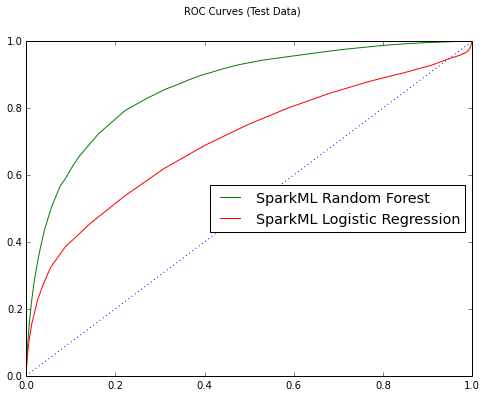

In [71]:
%matplotlib inline
pyplot.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.titlesize': 'xx-large',
    'legend.fontsize': 'x-large'})

fig, ax = pyplot.subplots()

ax.plot(
    [0, 1], [0, 1],
    linestyle='dotted')

ax.plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='SparkML Random Forest')

ax.plot(
    1 - lr_oos_performance.specificity,
    lr_oos_performance.recall,
    label='SparkML Logistic Regression')

ax.legend(loc='right')
fig.suptitle('ROC Curves (Test Data)')